Airbnb is a platform connecting travelers with unique accommodations worldwide. This analysis focuses on Airbnb data in New York City to uncover trends in the rental market.
Our goals include ranking neighborhoods by average rental prices, visualizing rental activity geographically, segmenting neighborhoods into price categories and finding relationships between different features, such as instant bookability of the property and its price. By analyzing this data, we aim to provide insights into NYC’s rental landscape for renters, hosts, and market analysts.
Each record represents a unique listing featuring an apartment/room available for rental, and one user's rating for it which will be the center of many aspects of our analysis.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
df = pd.read_csv("C:/Users/sherr/Downloads/Airbnb_Open_Data.csv/Airbnb_Open_Data.csv")
duplicates = df.duplicated()
print(f"Number of duplicated rows: {duplicates.sum()}")
df2 = df.drop_duplicates()
print("Duplicated rows removed.")

C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\376161339.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/sherr/Downloads/Airbnb_Open_Data.csv/Airbnb_Open_Data.csv")


Number of duplicated rows: 541
Duplicated rows removed.


Checking if the dataset is, indeed, concerned only with the US rental market and not including other countries.

In [44]:
unique_values = df2['country'].unique()

# Print the unique values
print(f'Unique values in "country": {unique_values}')

Unique values in "country": ['United States' nan]


Renaming columns for better readibility and maintenance. 

In [45]:
df2 = df2.rename(columns={'id': 'Listing ID',
                        'host id': 'Host ID',
                        'host_identity_verified':'Host Identity',
                        'lat':'Latitude',
                        'long':'Longitude',
                         'cancellation_policy':'Cancellation Policy',
                         'review rate number':'Average listing rate out of 5',
                         'number of reviews':'Number of Reviews'})


Deleting irrelevant columns (we deleted number of reviews as we're interested in individual reviews, represented by the rows)

In [46]:
df2 = df2.drop(['NAME', 'host name',
              'country','country code',
              'minimum nights',
               'reviews per month','last review',
              'calculated host listings count','house_rules','license'], axis=1)

Converting "price" and "service fee" to float instead of currency and merging them in one column names "Total price"


In [47]:
PropertyData["price"] = (
    PropertyData["price"]
    .str.replace("$", "", regex=False)  
    .str.replace(",", "", regex=False) 
    .str.strip()                        
    .astype(float)                      
)


PropertyData["service fee"] = (
    PropertyData["service fee"]
    .str.replace("$", "", regex=False) 
    .str.replace(",", "", regex=False)  
    .str.strip()                       
    .astype(float)                      
)

PropertyData["Total price"] = PropertyData["price"] + PropertyData["service fee"]


We decided to group listings by each listing location (unique combinations of latitude and longitude), not listing id because the same apt may be in multiple listings and not host id for the same reason. We decided to take the mode of categorical features and the average of price and rating per apartment.

In [52]:
import pandas as pd
def fast_mode(series):
    return series.value_counts().idxmax() if not series.isna().all() else None
agg_funcs = {
    col: fast_mode for col in df2.columns 
    if col not in ['Latitude', 'Longitude', 'Average listing rate out of 5', 'Total price']
}
agg_funcs['Average listing rate out of 5'] = 'mean' 
agg_funcs['Total price'] = 'mean' 
PropertyData = PropertyData.groupby(['Latitude', 'Longitude'], as_index=False).agg(agg_funcs)


In [72]:
PropertyData = PropertyData.rename(columns={'Total price': 'Average Total Price',})
#PropertyData = PropertyData.drop(['price', 'service fee'], axis=1)
PropertyData = PropertyData.drop(['Number of Reviews'], axis=1)

Deleting missing values (we decided to delete them as their number is negligible compared to the number of records after performing "group by")

In [73]:
null_counts = PropertyData.isnull().sum()
print("Null values in each column after grouping by 'lat' and 'long':")
for column, null_count in null_counts.items():
    print(f"{column}: {null_count}")
num_records = PropertyData.shape[0]
print(f'Number of records after grouping by latitude and longitude and removing null values: {num_records}')

Null values in each column after grouping by 'lat' and 'long':
Latitude: 0
Longitude: 0
Listing ID: 0
Host ID: 0
Host Identity: 0
neighbourhood group: 0
neighbourhood: 0
instant_bookable: 0
Cancellation Policy: 0
room type: 0
Construction year: 0
availability 365: 0
Average listing rate out of 5: 0
Average Total Price: 0
Number of records after grouping by latitude and longitude and removing null values: 65966


In [74]:
PropertyData = PropertyData.dropna(subset=["Host Identity",
                                           "neighbourhood group",
                                           "neighbourhood",
                                           "instant_bookable",
                                           "Cancellation Policy",
                                           "Construction year",
                                           "Average listing rate out of 5",
                                           "availability 365","Average Total Price"])

In [75]:
PropertyData.head()

,Latitude,Longitude,Listing ID,Host ID,Host Identity,neighbourhood group,neighbourhood,instant_bookable,Cancellation Policy,room type,Construction year,availability 365,Average listing rate out of 5,Average Total Price
0,40.49979,-74.24084,8799812,82631851678,unconfirmed,Staten Island,Tottenville,True,moderate,Private room,2020.0,127.0,1.0,443.0
1,40.50456,-74.24984,30263847,4035113175,verified,Staten Island,Tottenville,False,flexible,Entire home/apt,2007.0,347.0,3.0,493.0
2,40.50641,-74.23059,26915252,95404405434,verified,Staten Island,Tottenville,False,strict,Entire home/apt,2008.0,299.0,5.0,68.0
3,40.50708,-74.24285,9439928,72639175396,verified,Staten Island,Tottenville,True,strict,Private room,2017.0,239.0,2.0,337.0
4,40.50863,-74.24135,32732628,52053384774,verified,Staten Island,Tottenville,True,moderate,Entire home/apt,2015.0,328.0,3.0,802.0


In [76]:
PropertyData.tail()

,Latitude,Longitude,Listing ID,Host ID,Host Identity,neighbourhood group,neighbourhood,instant_bookable,Cancellation Policy,room type,Construction year,availability 365,Average listing rate out of 5,Average Total Price
67157,40.91248,-73.84885,32720477,97252271449,verified,Bronx,Wakefield,False,flexible,Private room,2017.0,348.0,4.0,172.0
67158,40.91306,-73.89389,27528305,6960196715,verified,Bronx,North Riverdale,True,strict,Private room,2012.0,175.0,5.0,1253.0
67159,40.91310,-73.89518,32982820,13261637560,verified,Bronx,North Riverdale,False,strict,Private room,2005.0,88.0,4.0,211.0
67160,40.91685,-73.90136,31339727,96502958176,unconfirmed,Bronx,North Riverdale,False,strict,Shared room,2020.0,302.0,2.0,209.0
67161,40.91697,-73.90125,37042777,56650082509,unconfirmed,Bronx,North Riverdale,False,flexible,Shared room,2007.0,211.0,3.0,331.0


In [77]:
null_counts = PropertyData.isnull().sum()
print("Null values in each column after grouping by 'lat' and 'long':")
for column, null_count in null_counts.items():
    print(f"{column}: {null_count}")
num_records = PropertyData.shape[0]
print(f'Number of records after grouping by latitude and longitude and removing null values: {num_records}')

Null values in each column after grouping by 'lat' and 'long':
Latitude: 0
Longitude: 0
Listing ID: 0
Host ID: 0
Host Identity: 0
neighbourhood group: 0
neighbourhood: 0
instant_bookable: 0
Cancellation Policy: 0
room type: 0
Construction year: 0
availability 365: 0
Average listing rate out of 5: 0
Average Total Price: 0
Number of records after grouping by latitude and longitude and removing null values: 65966


Here, we wanted to identify outliers in the numeric columns using box plots.

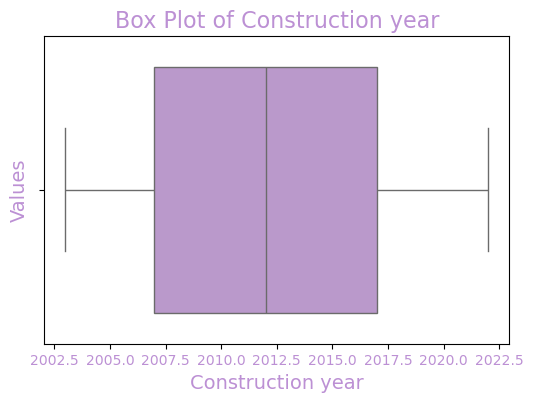

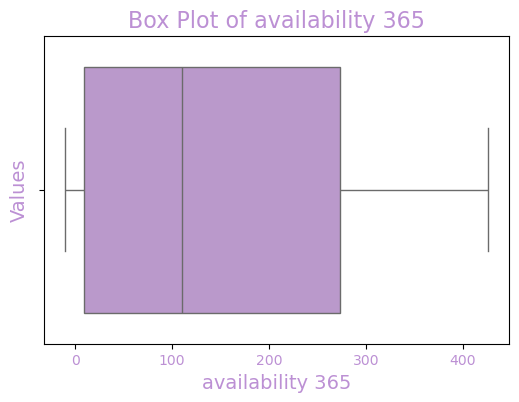

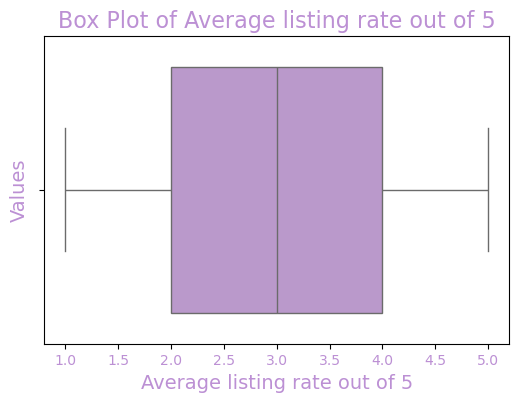

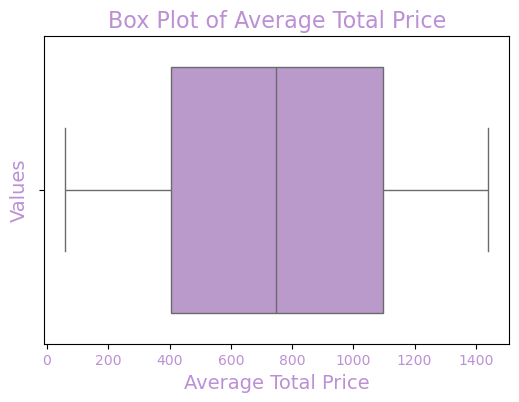

In [80]:
numeric_columns = PropertyData.select_dtypes(include=['number']).columns[-4:]
color = "#BC90D4" 

for column in numeric_columns:
    plt.figure(figsize=(6, 4)) 
    sns.boxplot(x=PropertyData[column], color=color)
    plt.title(f'Box Plot of {column}', fontsize=16, color=color)  
    plt.xlabel(column, fontsize=14, color=color)
    plt.ylabel('Values', fontsize=14, color=color)
    plt.xticks(color=color)
    plt.yticks(color=color)
    plt.show()

In [81]:
count_above_365 = PropertyData[PropertyData['availability 365'] > 365].shape[0]
print(f"Number of records with availability_365 greater than 365: {count_above_365}")

Number of records with availability_365 greater than 365: 1783


In [83]:
neighborhood_counts = PropertyData.groupby("neighbourhood")["Listing ID"].count().reset_index()

All cloumns are consistent except for the available 365 column which is supposed to display the number of days on which the property was available for rent all year around, we discovered that 2297 records have values more than 365. Since we don't know the source of this anomaly and the stakeholders aren't available to discuss it, we're going to assume there is a data entry error and assign 365 to values greater than 365

In [84]:
PropertyData['availability 365'] = PropertyData['availability 365'].apply(lambda x: 365 if x > 365 else x)
PropertyData = PropertyData[PropertyData['availability 365'] > 0]
PropertyData.reset_index(drop=True, inplace=True)
print(PropertyData['availability 365'].describe())

count    52285.000000
mean       183.177986
std        123.485975
min          1.000000
25%         68.000000
50%        175.000000
75%        307.000000
max        365.000000
Name: availability 365, dtype: float64


In [85]:
PropertyData.to_csv("PropertyData.csv", index=False)

Here we created a heat map to represent the most neighbourhood groups in which apartments are up for rent (most repeated neighborhoods in the rating dataset, hence their users may be prioritized in marketing campagins decided by the stakeholders).

In [87]:
import folium
from folium.plugins import HeatMap, Search
from folium import GeoJson
import json
neighborhood_counts = PropertyData['neighbourhood'].value_counts().reset_index()
neighborhood_counts.columns = ['neighbourhood', 'count']
locations = PropertyData.merge(neighborhood_counts, on='neighbourhood')
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
heat_data = [
    [row['Latitude'], row['Longitude'], row['count']]
    for index, row in locations.iterrows()
]
HeatMap(
    heat_data,
    radius=10,
    blur=5,
).add_to(nyc_map)
features = []
for idx, row in locations.drop_duplicates('neighbourhood').iterrows():
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [row['Longitude'], row['Latitude']]
        },
        "properties": {
            "name": row['neighbourhood'],
            "count": str(row['count']) + " properties"
        }
    }
    features.append(feature)

feature_collection = {"type": "FeatureCollection", "features": features}
neighborhood_layer = GeoJson(
    feature_collection,
    name="Neighborhoods",
    style_function=lambda x: {"fillOpacity": 0, "opacity": 0},  # Make points invisible
    tooltip=folium.GeoJsonTooltip(fields=['name', 'count'], 
                                 aliases=['Neighborhood:', 'Count:'],
                                 style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"))
)
neighborhood_layer.add_to(nyc_map)
search = Search(
    layer=neighborhood_layer,
    geom_type='Point',
    placeholder='Search for a neighborhood',
    collapsed=False,
    search_label='name',
    weight=3
).add_to(nyc_map)
nyc_map.save('nyc_neighborhood_searchable_heatmap.html')

We assumed it might be in the stakeholder's interest to find the neighborhoods with highest renting prices. Since the neighborhood column has so many unique values, we decided to operate on the neighborhood group column instead. It features the six main boroughs of New York City: 'Staten Island' 'Queens' 'Brooklyn' 'brookln' 'Manhattan' 'Bronx'. 

In [88]:
unique_neighborhoods = PropertyData['neighbourhood group'].unique()
print("Unique neighborhoods:", unique_neighborhoods)

Unique neighborhoods: ['Staten Island' 'Queens' 'Brooklyn' 'brookln' 'Manhattan' 'Bronx']


We noticed that Brooklyn is repeated twice and the second time it is misspelled. After identifying the approximate location of "Brooklyn" and "brookln" on the map we inferred that the second spelling most likely refers to western Brooklyn, and the former to Eastern Brooklyn. We modified their names accordingly. 

In [89]:
PropertyData['neighbourhood group'] = PropertyData['neighbourhood group'].replace('Brooklyn', 'East Brooklyn')
PropertyData['neighbourhood group'] = PropertyData['neighbourhood group'].replace('brookln', 'West Brooklyn')


C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\3177875152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PropertyData['neighbourhood group'] = PropertyData['neighbourhood group'].replace('Brooklyn', 'East Brooklyn')
C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\3177875152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PropertyData['neighbourhood group'] = PropertyData['neighbourhood group'].replace('brookln', 'West Brooklyn')


We then created a cluster map , with pins fixed on the center of each borough, taking gradient colors to represent the highest to lowest areas with respect to average house renting prices.

In [93]:
grouped_data = PropertyData.groupby('neighbourhood group')['Average Total Price'].mean().reset_index()
grouped_data['price_rank'] = pd.qcut(grouped_data['Average Total Price'], 
                                   q=3, 
                                   labels=['Low', 'Medium', 'High'])
color_map = {
    'High': '#FF0000',
    'Medium': '#FFA500',
    'Low': '#FFFF00'
}
center_lat = PropertyData['Latitude'].mean()
center_lon = PropertyData['Longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], 
               zoom_start=11)
for idx, row in grouped_data.iterrows():
    neighborhood_coords = PropertyData[PropertyData['neighbourhood group'] == row['neighbourhood group']]
    avg_lat = neighborhood_coords['Latitude'].mean()
    avg_lon = neighborhood_coords['Longitude'].mean()
    popup_text = f"""
    Neighborhood Group: {row['neighbourhood group']}
    Average Rental Price: ${row['Average Total Price']:,.2f}
    Price Level: {row['price_rank']}
    """
    folium.CircleMarker(
        location=[avg_lat, avg_lon],
        radius=15,
        popup=popup_text,
        color=color_map[row['price_rank']],
        fill=True,
        fill_color=color_map[row['price_rank']]
    ).add_to(m)
    
map_file = 'nyc_rental_clusters.html'
m.save(map_file)

We then performed a horizontal bar plot to feature the top 5 highest rated neighborhoods in our dataset, with their corresponding borough.

C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\2872229385.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


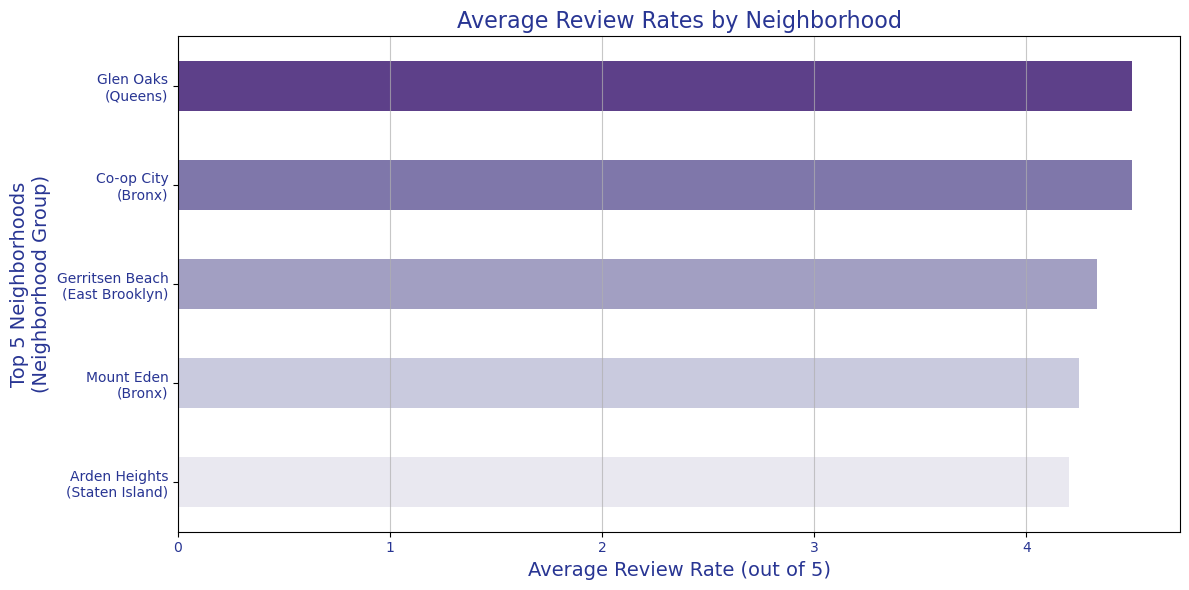

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the Mako color palette
purple_gradient = sns.color_palette("Purples", n_colors=5)[::-1]

# Find the top 5 neighborhoods by average rating
top_neighbourhoods = (
    PropertyData.groupby('neighbourhood')['Average listing rate out of 5']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# Create labels with neighborhood and group information
top_labels = []
for hood in top_neighbourhoods.index:
    group = PropertyData[PropertyData['neighbourhood'] == hood]['neighbourhood group'].iloc[0]
    top_labels.append(f"{hood}\n({group})")

# Plot the data
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    y=top_labels, 
    x=top_neighbourhoods.values, 
    palette=purple_gradient,  # Use the Mako palette
    width=0.5
)

# Add titles and labels with consistent color
plt.title('Average Review Rates by Neighborhood', fontsize=16, color="#283593")  # Indigo title
plt.xlabel('Average Review Rate (out of 5)', fontsize=14, color="#283593")
plt.ylabel('Top 5 Neighborhoods\n(Neighborhood Group)', fontsize=14, color="#283593")
plt.grid(axis='x', alpha=0.7)
plt.xticks(fontsize=10, color="#283593")
plt.yticks(fontsize=10, color="#283593")
plt.tight_layout()

# Display the plot
plt.show()


We performed a line chart visualization to find out whether the construction year affects the rental price

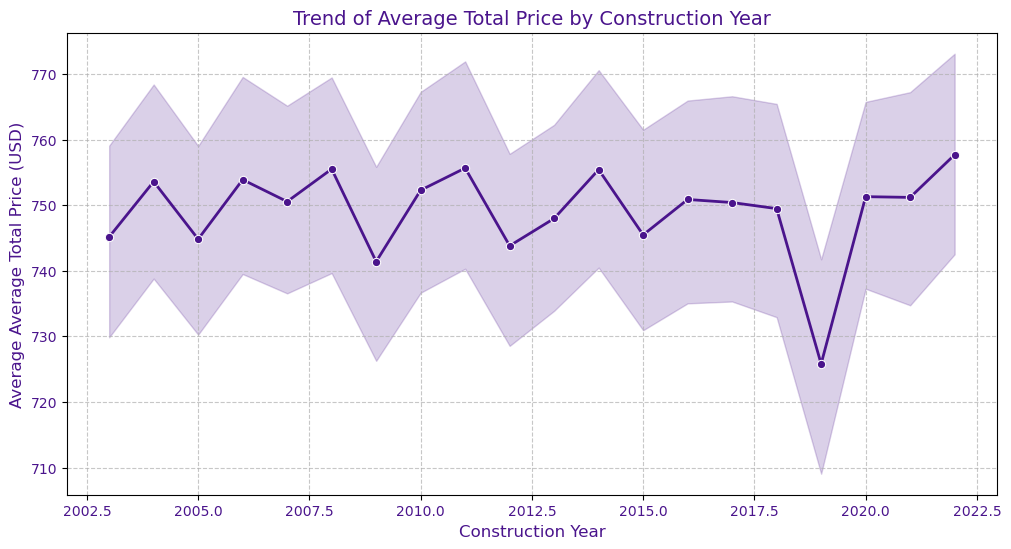

In [96]:
#How does construction year affect on price ?
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=PropertyData, 
    x='Construction year', 
    y='Average Total Price', 
    marker='o', 
    color="#4A148C",
    linewidth=2
)
plt.title('Trend of Average Total Price by Construction Year', fontsize=14, color="#4A148C")
plt.xlabel('Construction Year', fontsize=12, color="#4A148C")
plt.ylabel('Average Average Total Price (USD)', fontsize=12, color="#4A148C")
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(color="#4A148C")
plt.yticks(color="#4A148C")

plt.show()

A bar graph to answer the question: "Are some property types (rooms, apt, etc) available more than others all year around?

C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\2143863866.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=PropertyData, x='room type', y='availability 365',palette=purple_gradient, errorbar=None)
C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\2143863866.py:3: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(data=PropertyData, x='room type', y='availability 365',palette=purple_gradient, errorbar=None)


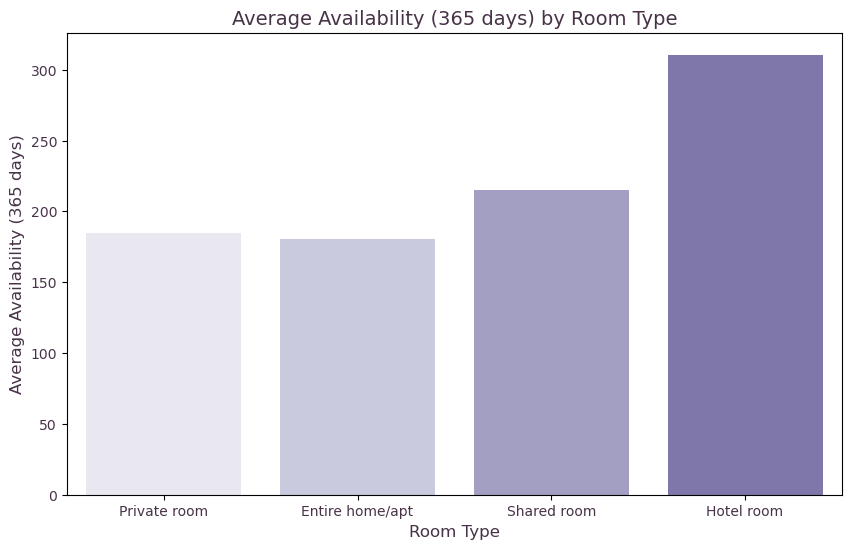

In [98]:
purple_gradient = sns.color_palette("Purples", n_colors=5)
plt.figure(figsize=(10, 6))
sns.barplot(data=PropertyData, x='room type', y='availability 365',palette=purple_gradient, errorbar=None)
plt.title('Average Availability (365 days) by Room Type', fontsize=14,color="#483248")
plt.xlabel('Room Type', fontsize=12,color="#483248")
plt.ylabel('Average Availability (365 days)', fontsize=12, color="#483248")
plt.xticks(color="#483248")
plt.yticks(color="#483248")
plt.show()

We use a count plot to visualize the frequency distribution of categorical data. It shows how often each category occurs in a dataset, making it useful for understanding the distribution of values in a particular variable.
The count plot in this case helps to compare the frequency of ratings between two categories of hosts, allowing us to visually analyze if the Host Identity (Verified vs. Unconfirmed) has an impact on the Listing rate out of 5.


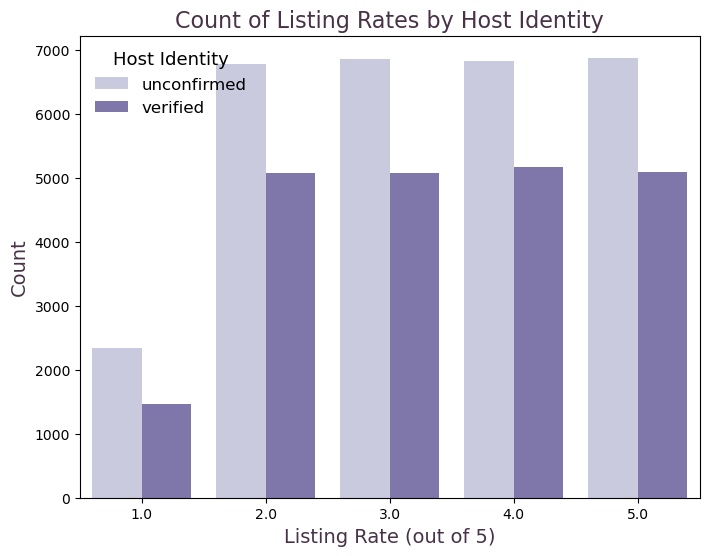

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
valid_rates = [1, 2, 3, 4, 5]
filtered_data = PropertyData[PropertyData['Average listing rate out of 5'].isin(valid_rates)]

purple_gradient = sns.color_palette("Purples", n_colors=2)

plt.figure(figsize=(8, 6))
sns.countplot(x='Average listing rate out of 5', hue='Host Identity', data=filtered_data, palette=purple_gradient)

plt.title('Count of Listing Rates by Host Identity', fontsize=16, color="#483248")
plt.xlabel('Listing Rate (out of 5)', fontsize=14, color="#483248")
plt.ylabel('Count', fontsize=14, color="#483248")
plt.legend(title='Host Identity', fontsize=12, title_fontsize='13', loc='upper left', frameon=False)

plt.show()


The box plot will show the spread of total prices for both True and False categories. It will show the median, quartiles, and any outliers for each group, which can give us more insight into whether instant bookable listings tend to have a higher price and if there is a large variation in the prices. 

We can modify this code to identify the relationship between cancellation policy and total price as well. And in that case, The box plot will show the distribution of total prices within each cancellation policy group. We can see the median, quartiles, and any outliers for the different cancellation policies, helping to assess if one policy type tends to have higher price.

C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\1424150256.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='instant_bookable', y='Average Total Price', data=PropertyData, palette=purple_gradient) ##Or cancellation policy


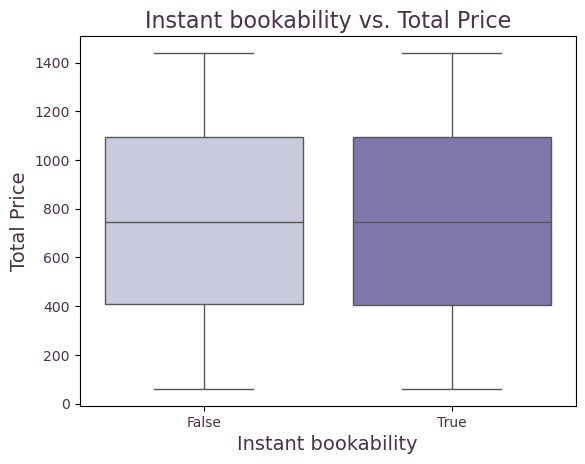

In [106]:
purple_gradient = sns.color_palette("Purples", n_colors=2)
sns.boxplot(x='instant_bookable', y='Average Total Price', data=PropertyData, palette=purple_gradient) ##Or cancellation policy

plt.title('Instant bookability vs. Total Price', fontsize=16, color="#483248")
plt.xlabel('Instant bookability', fontsize=14, color="#483248")
plt.ylabel('Total Price', fontsize=14, color="#483248")
plt.xticks(color="#483248")
plt.yticks(color="#483248")

plt.show()

C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\1108017803.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_labels, x=top_neighbourhoods.values, palette=purple_gradient, width=0.5, ax=axes[0, 0])
C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\1108017803.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=PropertyData, x='room type', y='availability 365', palette=purple_gradient, errorbar=None, ax=axes[1, 0])
C:\Users\sherr\AppData\Local\Temp\ipykernel_30672\1108017803.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(

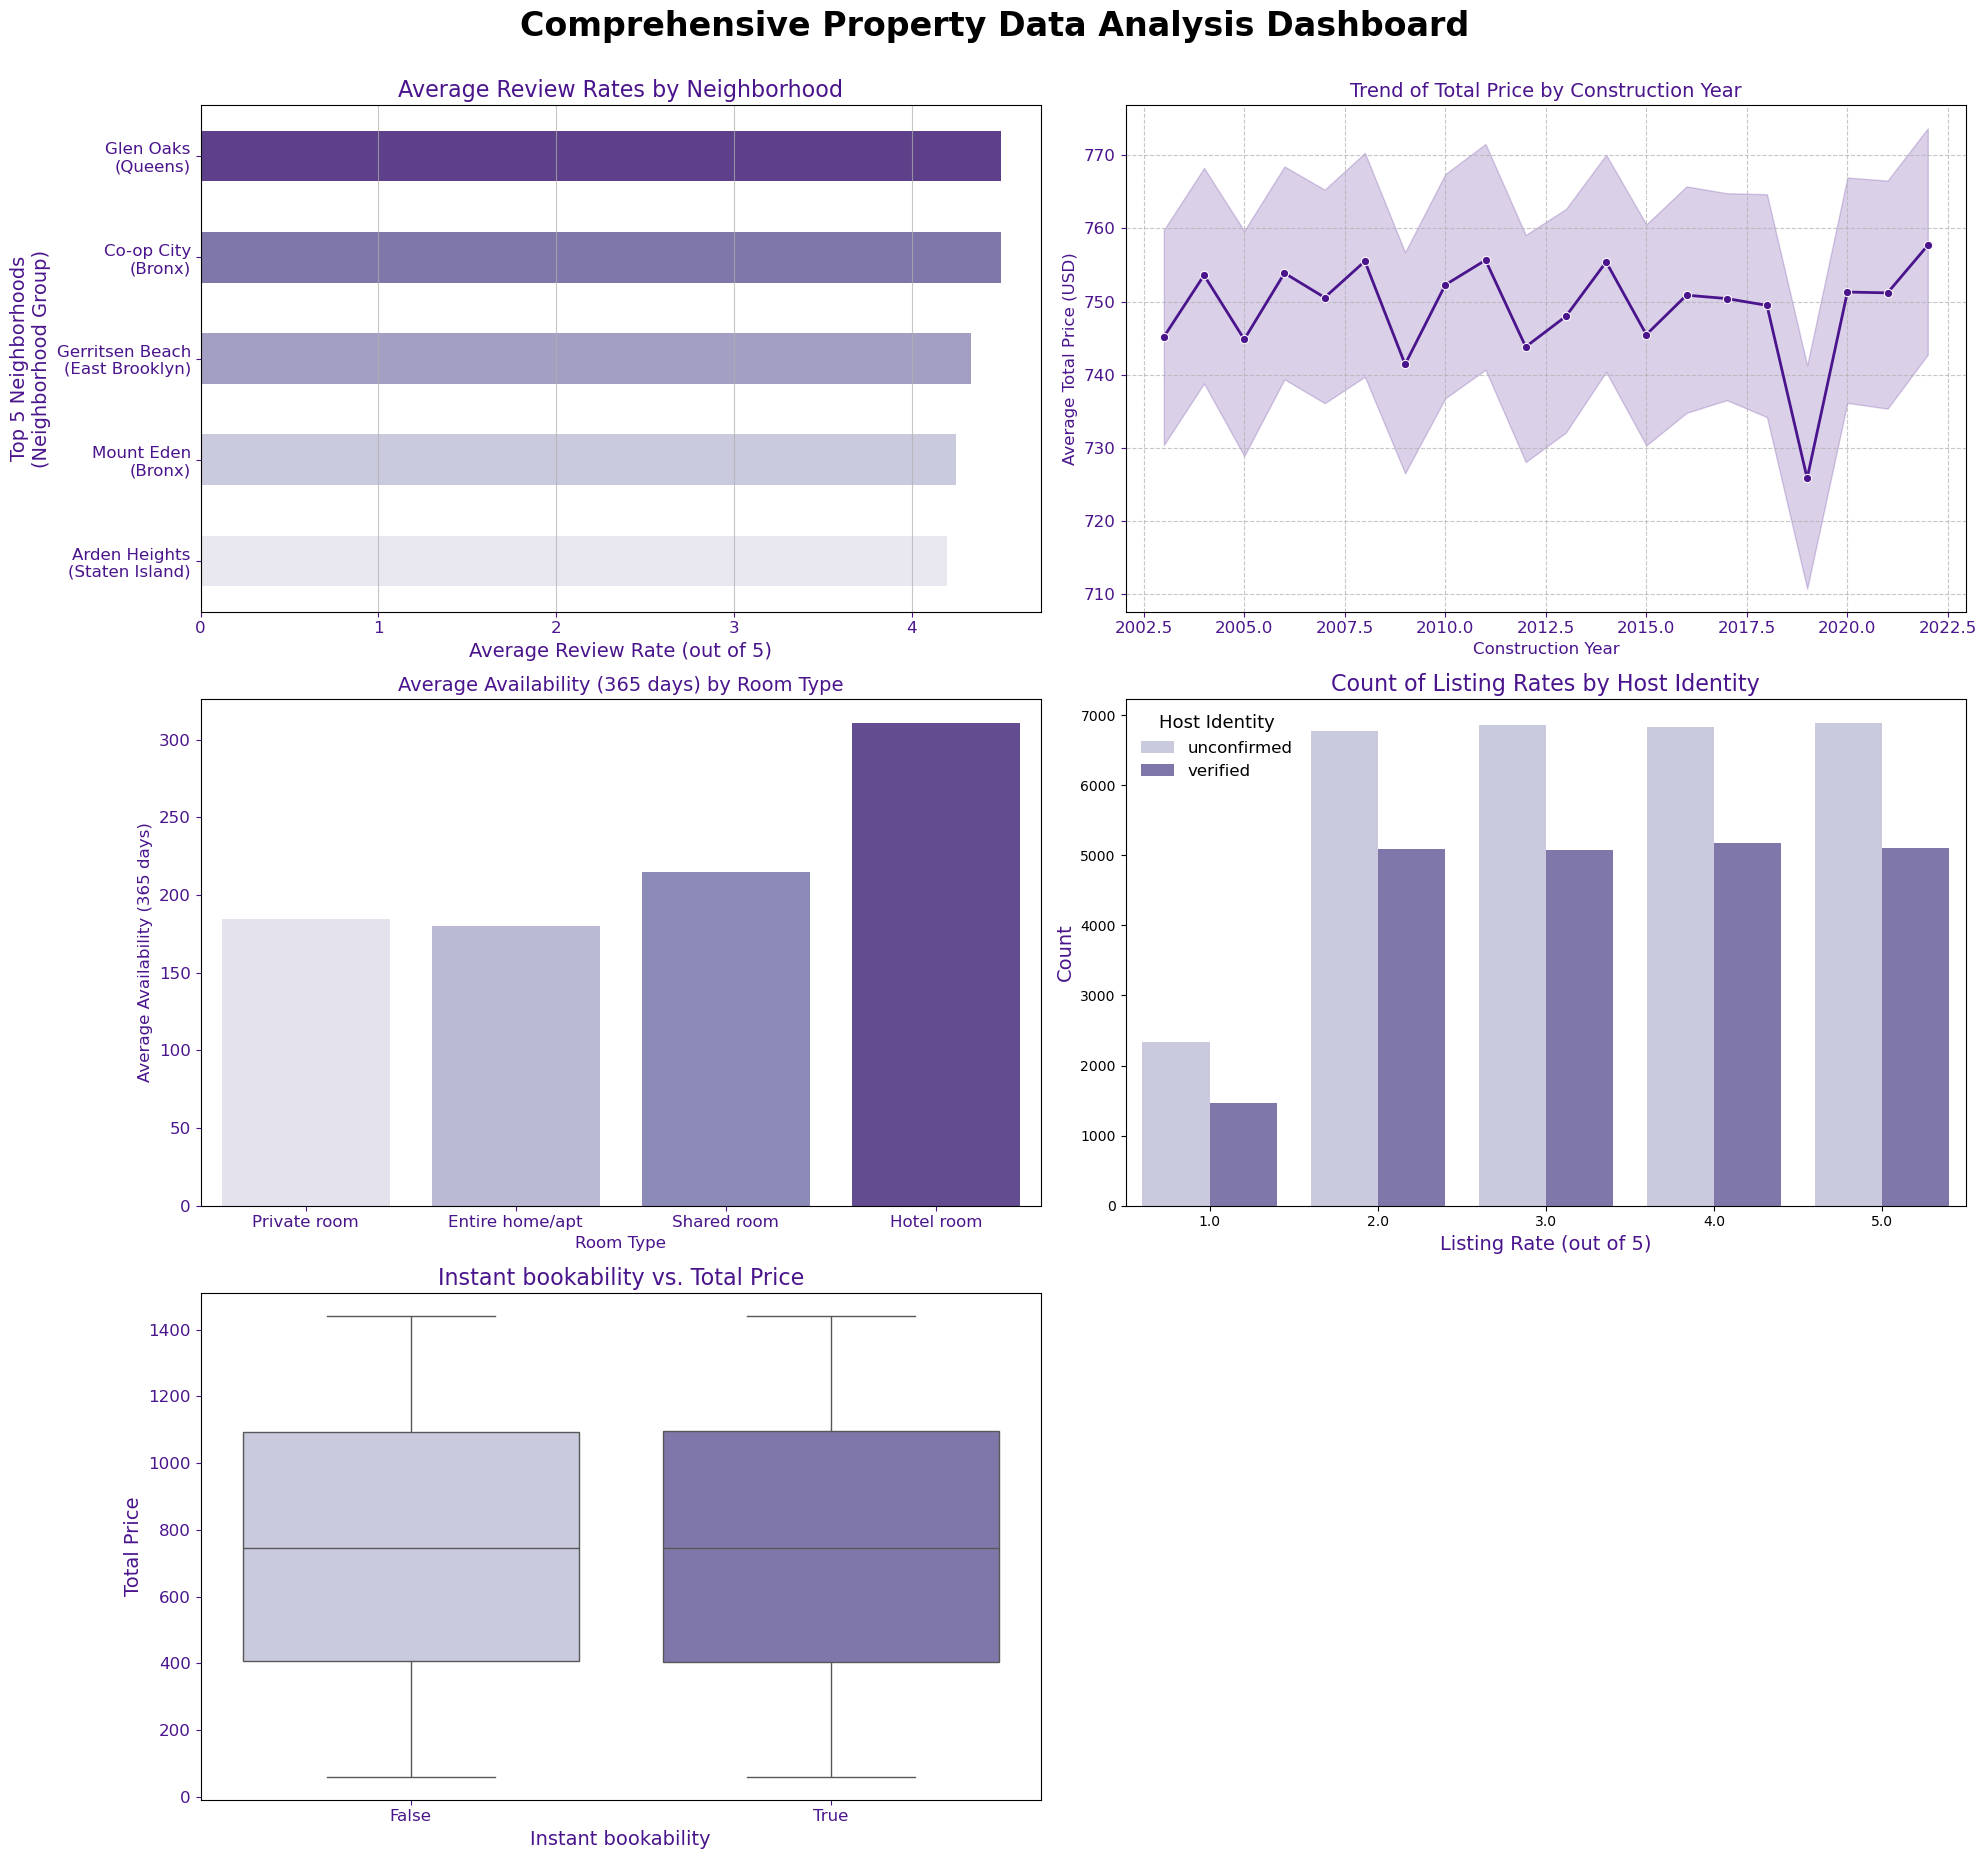

In [111]:

# 1. Average Review Rates by Neighborhood
top_neighbourhoods = PropertyData.groupby('neighbourhood')['Average listing rate out of 5'].mean().sort_values(ascending=False).head(5)
top_labels = []
for hood in top_neighbourhoods.index:
    group = PropertyData[PropertyData['neighbourhood'] == hood]['neighbourhood group'].iloc[0]
    top_labels.append(f"{hood}\n({group})")
    
# Create a grid of three rows and two columns
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Plot 1: Average Review Rates by Neighborhood
purple_gradient = sns.color_palette("Purples", n_colors=5)[::-1]
sns.barplot(y=top_labels, x=top_neighbourhoods.values, palette=purple_gradient, width=0.5, ax=axes[0, 0])
axes[0, 0].set_title('Average Review Rates by Neighborhood', fontsize=16, color="#4A148C")
axes[0, 0].set_xlabel('Average Review Rate (out of 5)', fontsize=14, color="#4A148C")
axes[0, 0].set_ylabel('Top 5 Neighborhoods\n(Neighborhood Group)', fontsize=14, color="#4A148C")
axes[0, 0].tick_params(axis='both', labelsize=12, colors="#4A148C")
axes[0, 0].grid(axis='x', alpha=0.7)

# Plot 2: Trend of Total Price by Construction Year
sns.lineplot(data=PropertyData, x='Construction year', y='Average Total Price', marker='o', color="#4A148C", linewidth=2, ax=axes[0, 1])
axes[0, 1].set_title('Trend of Total Price by Construction Year', fontsize=14, color="#4A148C")
axes[0, 1].set_xlabel('Construction Year', fontsize=12, color="#4A148C")
axes[0, 1].set_ylabel('Average Total Price (USD)', fontsize=12, color="#4A148C")
axes[0, 1].tick_params(axis='both', labelsize=12, colors="#4A148C")
axes[0, 1].grid(linestyle='--', alpha=0.7)

# Plot 3: Average Availability by Room Type
purple_gradient = sns.color_palette("Purples", n_colors=4)
sns.barplot(data=PropertyData, x='room type', y='availability 365', palette=purple_gradient, errorbar=None, ax=axes[1, 0])
axes[1, 0].set_title('Average Availability (365 days) by Room Type', fontsize=14, color="#4A148C")
axes[1, 0].set_xlabel('Room Type', fontsize=12, color="#4A148C")
axes[1, 0].set_ylabel('Average Availability (365 days)', fontsize=12, color="#4A148C")
axes[1, 0].tick_params(axis='both', labelsize=12, colors="#4A148C")

# Plot 4: Count of Listing Rates by Host Identity
import seaborn as sns
valid_rates = [1, 2, 3, 4, 5]
filtered_data = PropertyData[PropertyData['Average listing rate out of 5'].isin(valid_rates)]
purple_gradient = sns.color_palette("Purples", n_colors=2)
sns.countplot(x='Average listing rate out of 5', hue='Host Identity', data=filtered_data, palette=purple_gradient, ax=axes[1, 1])
axes[1, 1].set_title('Count of Listing Rates by Host Identity', fontsize=16, color="#4A148C")
axes[1, 1].set_xlabel('Listing Rate (out of 5)', fontsize=14, color="#4A148C")
axes[1, 1].set_ylabel('Count', fontsize=14, color="#4A148C")
axes[1, 1].legend(title='Host Identity', fontsize=12, title_fontsize='13', loc='upper left', frameon=False)


# Plot 5: Instant bookability vs. Total Price
sns.boxplot(x='instant_bookable', y='Average Total Price', data=PropertyData, palette=purple_gradient, ax=axes[2, 0])
axes[2, 0].set_title('Instant bookability vs. Total Price', fontsize=16, color="#4A148C")
axes[2, 0].set_xlabel('Instant bookability', fontsize=14, color="#4A148C")
axes[2, 0].set_ylabel('Total Price', fontsize=14, color="#4A148C")
axes[2, 0].tick_params(axis='both', labelsize=12, colors="#4A148C")

# Remove the unused space from the grid
axes[2, 1].axis('off')

# Adjust layout for better readability and add a main title
plt.tight_layout()
fig.suptitle('Comprehensive Property Data Analysis Dashboard', fontsize=24, weight='bold', y=1.03)

plt.show()
